<a href="https://colab.research.google.com/github/karipuf/crypto/blob/master/Cryptooo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting stuff up

In [ ]:
!pip install Historic-Crypto
!pip install pyspark

In [75]:
from Historic_Crypto import HistoricalData,Cryptocurrencies,LiveCryptoData
import pylab as pl
import pyspark,lightgbm,sklearn,pandas as pd,pyspark.sql.functions as F
from pyspark.sql.window import Window
from itertools import count
from functools import reduce

spark=pyspark.sql.SparkSession.builder.getOrCreate()

In [71]:
# Local definitions

rollback=lambda l,n:Window.orderBy("time").rowsBetween(-(l+n),Window.currentRow-n)
def rollingRows(coins=['btc','eth','ltc'],winlens=[3,7],
                avg_kpis=["open","close","volume"],
                min_kpis=['low'],max_kpis=['high'],lag=3):
  
  rows=[]
  for l in winlens:
    rows.append([F.avg(tmp).over(rollback(l,lag)).alias(f"{tmp}_rolling{l}") for tmp in 
    (f"{coin}_{kpi}" for coin in coins for kpi in avg_kpis)])
    rows.append([F.min(tmp).over(rollback(l,lag)).alias(f"{tmp}_rolling{l}") for tmp in 
    (f"{coin}_{kpi}" for coin in coins for kpi in min_kpis)])
    rows.append([F.max(tmp).over(rollback(l,lag)).alias(f"{tmp}_rolling{l}") for tmp in 
    (f"{coin}_{kpi}" for coin in coins for kpi in max_kpis)])

  return reduce(lambda x,y:x+y,rows)

### Get some data to play about with

In [45]:
# Generate list of currencies
pf=Cryptocurrencies(coin_search="USD").find_crypto_pairs()

# Loading in data
if False: # To exclude those that are already done

  # Loading
  btc = HistoricalData('BTC-USD',300,'2020-06-01-00-00').retrieve_data()
  eth = HistoricalData('ETH-USD',300,'2020-06-01-00-00').retrieve_data()
  ltc = HistoricalData('LTC-USD',300,'2020-06-01-00-00').retrieve_data()

  # Writing.
  btc.to_csv("/content/drive/MyDrive/colab_files/data/btc.csv")
  eth.to_csv("/content/drive/MyDrive/colab_files/data/eth.csv")
  ltc.to_csv("/content/drive/MyDrive/colab_files/data/ltc.csv")

else:

  pbtc=pd.read_csv("/content/drive/MyDrive/colab_files/data/btc.csv")
  peth=pd.read_csv("/content/drive/MyDrive/colab_files/data/eth.csv")
  pltc=pd.read_csv("/content/drive/MyDrive/colab_files/data/ltc.csv")

  deth=spark.createDataFrame(peth.reset_index())
  dbtc=spark.createDataFrame(pbtc.reset_index())
  dltc=spark.createDataFrame(pltc.reset_index())

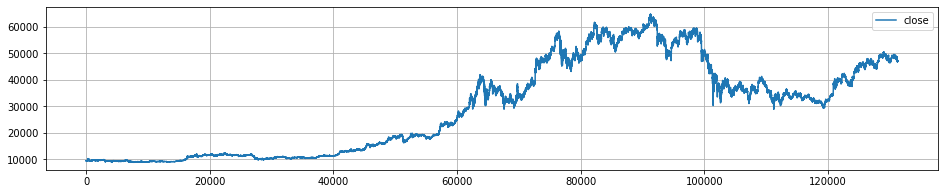

In [47]:
pl.figure(figsize=(16,3))
pbtc.plot(y='close',ax=pl.gca())
pl.gca().grid(True)

In [72]:
combined=(reduce(lambda x,y:x.join(y,"time"),
          [dbtc.alias("dbtc"),deth.alias("deth"),dltc.alias("dltc")])
.select("time",*[F.expr(f"d{coin}.{kpi}").alias(f"{coin}_{kpi}")
    for kpi in ('open','close','low','high','volume')
    for coin in ('btc','eth','ltc')]).orderBy("time"))

df=(combined.alias("combined").select("combined.*",*rollingRows())\
.withColumn("row",F.rank().over(Window.orderBy("time"))).where("row>10") # Removing first n rows to allow for rolling windows
.orderBy("time"))

display(df.limit(3).toPandas())

,time,btc_open,eth_open,ltc_open,btc_close,eth_close,ltc_close,btc_low,eth_low,ltc_low,btc_high,eth_high,ltc_high,btc_volume,eth_volume,ltc_volume,btc_open_rolling3,btc_close_rolling3,btc_volume_rolling3,eth_open_rolling3,eth_close_rolling3,eth_volume_rolling3,ltc_open_rolling3,ltc_close_rolling3,ltc_volume_rolling3,btc_low_rolling3,eth_low_rolling3,ltc_low_rolling3,btc_high_rolling3,eth_high_rolling3,ltc_high_rolling3,btc_open_rolling7,btc_close_rolling7,btc_volume_rolling7,eth_open_rolling7,eth_close_rolling7,eth_volume_rolling7,ltc_open_rolling7,ltc_close_rolling7,ltc_volume_rolling7,btc_low_rolling7,eth_low_rolling7,ltc_low_rolling7,btc_high_rolling7,eth_high_rolling7,ltc_high_rolling7,row
0,2020-06-01 00:55:00,9478.46,232.69,45.78,9496.15,233.15,45.84,9478.46,232.57,45.77,9505.70,233.23,45.87,158.074283,233.791027,738.579154,9475.9475,9471.1150,20.582157,232.8775,232.6825,351.196669,45.7975,45.7725,421.570335,9455.31,231.9,45.70,9487.83,233.41,45.84,9469.28125,9473.35875,29.336577,232.6100,232.75750,529.601735,45.72250,45.76875,478.871710,9426.26,230.91,45.37,9492.77,233.68,45.85,11
1,2020-06-01 01:00:00,9496.15,233.14,45.86,9489.98,233.23,45.82,9485.83,232.88,45.80,9500.01,233.23,45.87,64.382889,494.048485,147.100535,9471.7500,9469.6000,17.319064,232.6750,232.5450,287.156502,45.7600,45.7625,400.382088,9455.31,231.9,45.67,9487.83,233.41,45.83,9473.67000,9474.43625,25.502253,232.7525,232.80750,409.945847,45.75875,45.78375,384.768656,9455.31,231.90,45.67,9492.77,233.68,45.85,12
2,2020-06-01 01:05:00,9489.98,233.19,45.82,9484.56,232.93,45.79,9480.52,232.82,45.78,9494.87,233.23,45.82,33.837943,92.167659,46.467917,9470.7300,9472.9325,17.065967,232.5375,232.5400,351.736223,45.7525,45.7725,395.101619,9455.31,231.9,45.67,9487.94,233.00,45.82,9474.56625,9474.64750,22.372068,232.7975,232.76875,404.007839,45.77375,45.78750,312.964317,9455.31,231.90,45.67,9492.77,233.68,45.85,13


### Quick bit of feature engineering then build simple model

In [104]:
# Feature engineering

coins=['btc','eth','ltc']

# Range
featExprs=[f"({coin}_high_rolling{l}-{coin}_low_rolling{l})/{coin}_low_rolling{l} as {coin}_range_rolling{l}" 
           for coin in coins for l in [3,7]]
# Delta close
featExprs+=[f"""({coin}_close_rolling{lpair[1]}-{coin}_close_rolling{lpair[0]})/{coin}_close_rolling{lpair[1]} 
            as {coin}_delta_rolling{lpair[0]}_{lpair[1]}""" for coin in coins for lpair in [(7,3)]]
# Volume close
featExprs+=[f"""({coin}_volume_rolling{lpair[1]}-{coin}_volume_rolling{lpair[0]})/{coin}_volume_rolling{lpair[1]} 
            as {coin}_volume_rolling{lpair[0]}_{lpair[1]}""" for coin in coins for lpair in [(7,3)]]

# Day of week
featExprs+=["dayofweek(time) as dow"]

# Label
featExprs+=["(btc_close-btc_close_rolling3)/btc_close_rolling3 as label"]

display(df.selectExpr(featExprs).limit(3).toPandas())

,btc_range_rolling3,btc_range_rolling7,eth_range_rolling3,eth_range_rolling7,ltc_range_rolling3,ltc_range_rolling7,btc_delta_rolling7_3,eth_delta_rolling7_3,ltc_delta_rolling7_3,btc_volume_rolling7_3,eth_volume_rolling7_3,ltc_volume_rolling7_3,dow,label
0,0.003439,0.007056,0.006511,0.011996,0.003063,0.010580,-0.000237,-0.000322,0.000082,-0.425340,-0.507992,-0.135924,2,0.002643
1,0.003439,0.003962,0.006511,0.007676,0.003503,0.003941,-0.000511,-0.001129,-0.000464,-0.472496,-0.427604,0.038996,2,0.002152
2,0.003451,0.003962,0.004743,0.007676,0.003284,0.003941,-0.000181,-0.000984,-0.000328,-0.310917,-0.148610,0.207889,2,0.001227


In [ ]:
# Model!

### Simple data checks

In [83]:
# Low and high prices should always bracket all the other prices
df.groupby(*[F.expr(f"{coin}_close between {coin}_low and {coin}_high as {coin}_close_check")
           for coin in ['btc','eth','ltc']],
           *[F.expr(f"{coin}_open between {coin}_low and {coin}_high as {coin}_open_check")
           for coin in ['btc','eth','ltc']]).count().toPandas().T

,0
btc_close_check,True
eth_close_check,True
ltc_close_check,True
btc_open_check,True
eth_open_check,True
ltc_open_check,True
count,131250


In [76]:
print(f"num_rows: {df.count()}\n\ncolumns:\n-------")
for cols in [df.columns[tmp:tmp+5] for tmp in range(0,len(df.columns),5)]: print(", ".join(cols))

num_rows: 131250

columns:
-------
time, btc_open, eth_open, ltc_open, btc_close
eth_close, ltc_close, btc_low, eth_low, ltc_low
btc_high, eth_high, ltc_high, btc_volume, eth_volume
ltc_volume, btc_open_rolling3, btc_close_rolling3, btc_volume_rolling3, eth_open_rolling3
eth_close_rolling3, eth_volume_rolling3, ltc_open_rolling3, ltc_close_rolling3, ltc_volume_rolling3
btc_low_rolling3, eth_low_rolling3, ltc_low_rolling3, btc_high_rolling3, eth_high_rolling3
ltc_high_rolling3, btc_open_rolling7, btc_close_rolling7, btc_volume_rolling7, eth_open_rolling7
eth_close_rolling7, eth_volume_rolling7, ltc_open_rolling7, ltc_close_rolling7, ltc_volume_rolling7
btc_low_rolling7, eth_low_rolling7, ltc_low_rolling7, btc_high_rolling7, eth_high_rolling7
ltc_high_rolling7, row


### Scratch

In [ ]:
import requests
response = requests.get('https://api.coindesk.com/v1/bpi/currentprice.json')
data = response.json()
print(data)

{'time': {'updated': 'Aug 31, 2021 05:49:00 UTC', 'updatedISO': '2021-08-31T05:49:00+00:00', 'updateduk': 'Aug 31, 2021 at 06:49 BST'}, 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index (USD). Non-USD currency data converted using hourly conversion rate from openexchangerates.org', 'chartName': 'Bitcoin', 'bpi': {'USD': {'code': 'USD', 'symbol': '&#36;', 'rate': '47,195.4600', 'description': 'United States Dollar', 'rate_float': 47195.46}, 'GBP': {'code': 'GBP', 'symbol': '&pound;', 'rate': '34,250.5476', 'description': 'British Pound Sterling', 'rate_float': 34250.5476}, 'EUR': {'code': 'EUR', 'symbol': '&euro;', 'rate': '39,935.0992', 'description': 'Euro', 'rate_float': 39935.0992}}}


In [ ]:
/content/drive/MyDrive/colab_files